In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries (usually pre-installed in Colab)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Verify TensorFlow version
print("TensorFlow Version:", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow Version: 2.19.0


In [6]:
# Define dataset path (update with your actual path in Google Drive)
dataset_path = '/content/drive/MyDrive/computer_vision_2/dataset'  # Replace with your dataset path

# Get class names (subfolders)
class_names = sorted(os.listdir(dataset_path))
print("Classes:", class_names)
num_classes = len(class_names)

# Function to select a subset of images per class
def get_subset_data(dataset_path, max_images_per_class=100):
    subset_paths = []
    subset_labels = []
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        # Select up to max_images_per_class images
        selected_images = images[:min(max_images_per_class, len(images))]
        subset_paths.extend([os.path.join(class_path, img) for img in selected_images])
        subset_labels.extend([class_idx] * len(selected_images))
    return subset_paths, subset_labels

# Get subset
subset_paths, subset_labels = get_subset_data(dataset_path, max_images_per_class=100)
print(f"Total images in subset: {len(subset_paths)}")

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Total images in subset: 150


In [7]:
# Image parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(subset_paths, subset_labels, test_size=0.3, stratify=subset_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation/test

# Function to load and preprocess images
def create_dataframe(paths, labels):
    import pandas as pd
    return pd.DataFrame({'filename': paths, 'class': [str(label) for label in labels]})

# Create dataframes
train_df = create_dataframe(X_train, y_train)
val_df = create_dataframe(X_val, y_val)
test_df = create_dataframe(X_test, y_test)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 105 validated image filenames belonging to 15 classes.
Found 22 validated image filenames belonging to 15 classes.
Found 23 validated image filenames belonging to 15 classes.


In [5]:
# Define the custom CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.0631 - loss: 4.4249 - val_accuracy: 0.0909 - val_loss: 2.7141
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.0806 - loss: 2.7683 - val_accuracy: 0.0909 - val_loss: 2.7145
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.0874 - loss: 2.7095 - val_accuracy: 0.0909 - val_loss: 2.7143
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.0332 - loss: 2.7070 - val_accuracy: 0.0455 - val_loss: 2.7031
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.0245 - loss: 2.7145 - val_accuracy: 0.1364 - val_loss: 2.7060
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.0843 - loss: 2.7008 - val_accuracy: 0.0909 - val_loss: 2.6987
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.1086 - loss: 2.6906 - val_accuracy: 0.0455 - val_loss: 2.7047
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.0882 - loss: 2.6993 - val_accuracy: 0.0455 - val_loss: 2.6962
Epoch 9/

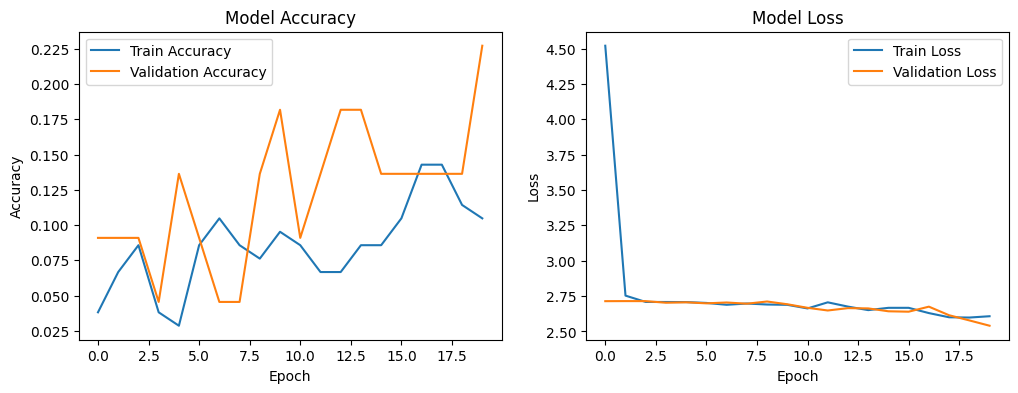

In [6]:
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.3395 - loss: 2.0085 - val_accuracy: 0.4091 - val_loss: 2.1328
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3079 - loss: 2.1830 - val_accuracy: 0.3636 - val_loss: 2.0925
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3459 - loss: 2.0919 - val_accuracy: 0.2727 - val_loss: 2.1448
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3171 - loss: 1.9647 - val_accuracy: 0.3636 - val_loss: 2.1294
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3511 - loss: 2.0764 - val_accuracy: 0.2727 - val_loss: 2.2041
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.3057 - loss: 1.9985 - val_accuracy: 0.4091 - val_loss: 2.1265
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.3482 - loss: 1.9608 - val_accuracy: 0.4091 - val_loss: 2.1293


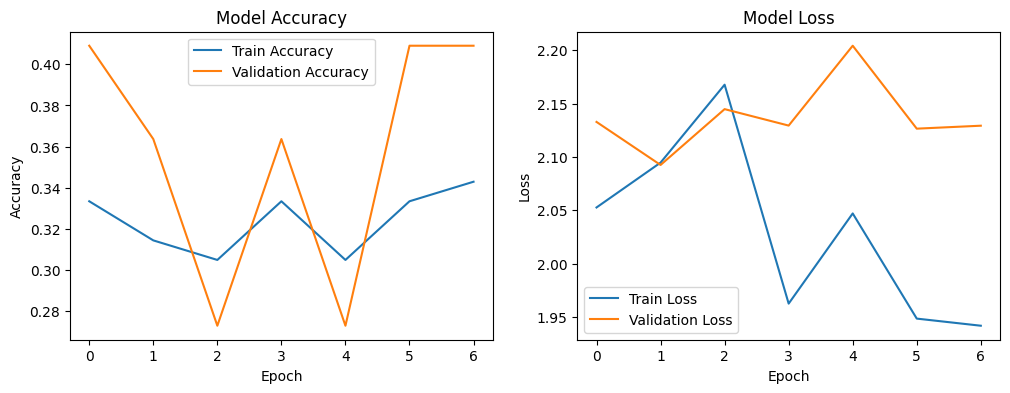

In [9]:
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3538 - loss: 1.9165
Epoch 1: val_loss improved from inf to 2.13111, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3573 - loss: 1.9243 - val_accuracy: 0.4091 - val_loss: 2.1311 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2826 - loss: 2.0063
Epoch 2: val_loss improved from 2.13111 to 2.03053, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.2927 - loss: 1.9933 - val_accuracy: 0.4545 - val_loss: 2.0305 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3961 - loss: 2.0311
Epoch 3: val_loss did not improve from 2.03053
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.3950 - loss: 2.0211 - val_accuracy: 0.3182 - val_loss: 2.0489 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3528 - loss: 1.8707
Epoch 4: val_loss did not improve from 2.03053
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3565 - loss: 1.8734 - val_accuracy: 0.1818 - val_loss: 2.5901 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2913 - loss: 2.1196
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 5: val_loss did not improve from 2.03053
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.2959 - loss: 2.1033 - val_accuracy: 0.3636 - val_loss: 2.1169 - learning_rat

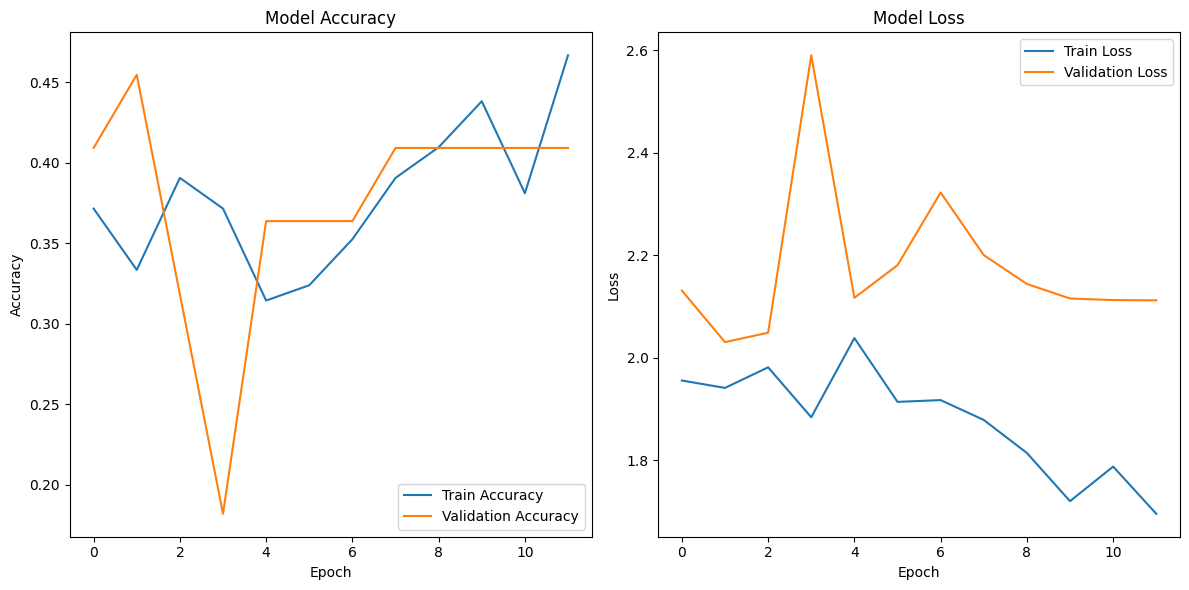

In [10]:
# Import required libraries
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience to allow more epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/custom_cnn_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot learning rate (if logged)
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3627 - loss: 1.9134
Epoch 1: val_loss improved from inf to 2.03209, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.3645 - loss: 1.8955 - val_accuracy: 0.4545 - val_loss: 2.0321 - learning_rate: 8.0000e-06
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3268 - loss: 2.0052
Epoch 2: val_loss did not improve from 2.03209
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.3281 - loss: 1.9993 - val_accuracy: 0.4545 - val_loss: 2.0373 - learning_rate: 8.0000e-06
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3199 - loss: 1.9879
Epoch 3: val_loss did not improve from 2.03209
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.3207 - loss: 1.9756 - val_accuracy: 0.4091 - val_loss: 2.0456 - learning_rate: 8.0000e-06
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4993 - loss: 1.7258
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 4: val_loss did not improve from 2.03209
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4852 - loss: 1.7532 - val_accuracy: 0.4091 - val_loss: 2.0530 - 

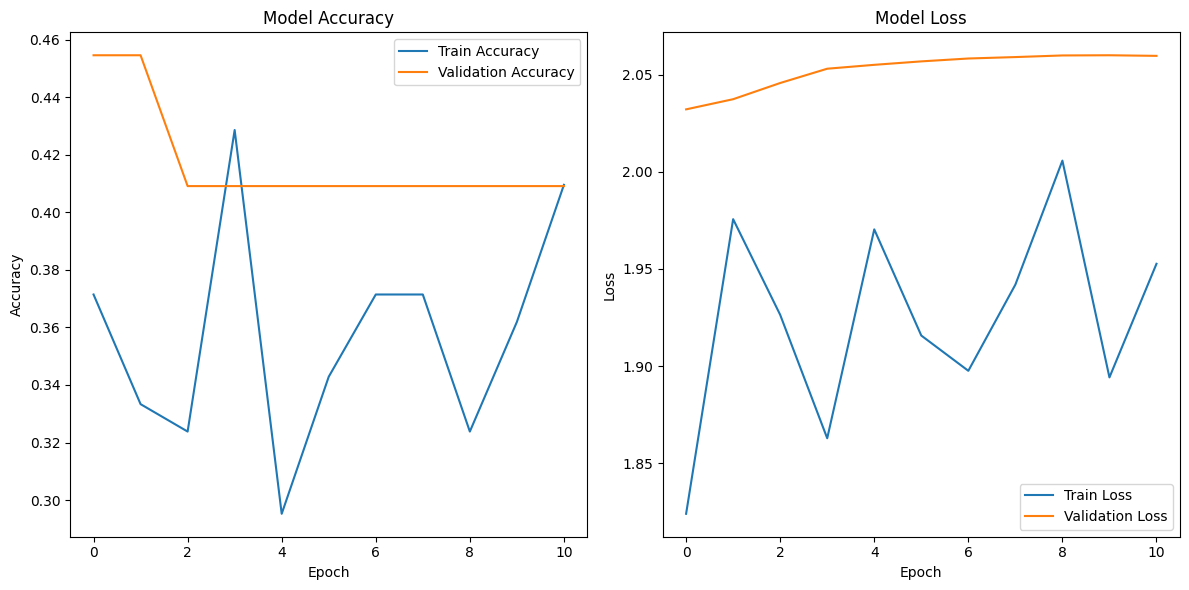

In [11]:
# Import required libraries
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience to allow more epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/custom_cnn_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot learning rate (if logged)
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3658 - loss: 1.9359
Epoch 1: val_loss improved from inf to 2.03206, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.3707 - loss: 1.9202 - val_accuracy: 0.4545 - val_loss: 2.0321 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3868 - loss: 1.8183
Epoch 2: val_loss did not improve from 2.03206
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.3990 - loss: 1.8130 - val_accuracy: 0.4545 - val_loss: 2.0326 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3898 - loss: 1.8009
Epoch 3: val_loss did not improve from 2.03206
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3747 - loss: 1.8311 - val_accuracy: 0.4545 - val_loss: 2.0332 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3511 - loss: 1.9465
Epoch 4: val_loss did not improve from 2.03206
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3514 - loss: 1.9440 - val_accuracy: 0.4545 - val_loss: 2.0335 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step -

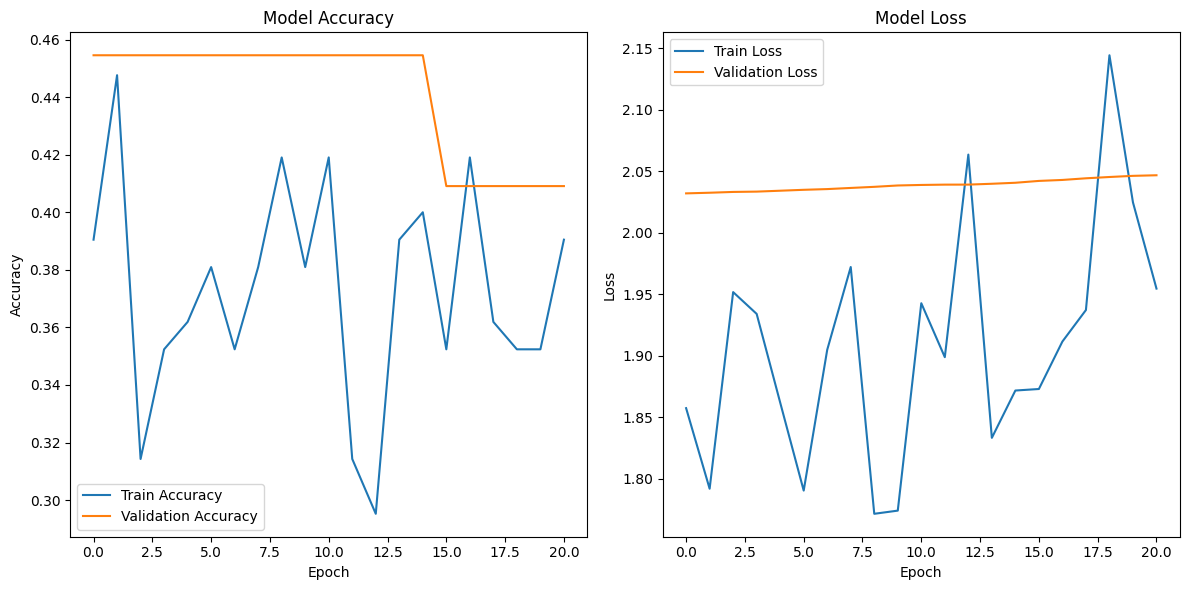

In [12]:
# Import required libraries
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased patience to allow more epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/custom_cnn_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot learning rate (if logged)
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3516 - loss: 1.8471
Epoch 1: val_loss improved from inf to 2.03260, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.3536 - loss: 1.8440 - val_accuracy: 0.4545 - val_loss: 2.0326 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4123 - loss: 1.7833
Epoch 2: val_loss did not improve from 2.03260
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.4061 - loss: 1.8033 - val_accuracy: 0.4545 - val_loss: 2.0332 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3970 - loss: 1.8440
Epoch 3: val_loss did not improve from 2.03260
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3957 - loss: 1.8453 - val_accuracy: 0.4545 - val_loss: 2.0339 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3199 - loss: 1.8140
Epoch 4: val_loss did not improve from 2.03260
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.3245 - loss: 1.8260 - val_accuracy: 0.4545 - val_loss: 2.0351 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step -

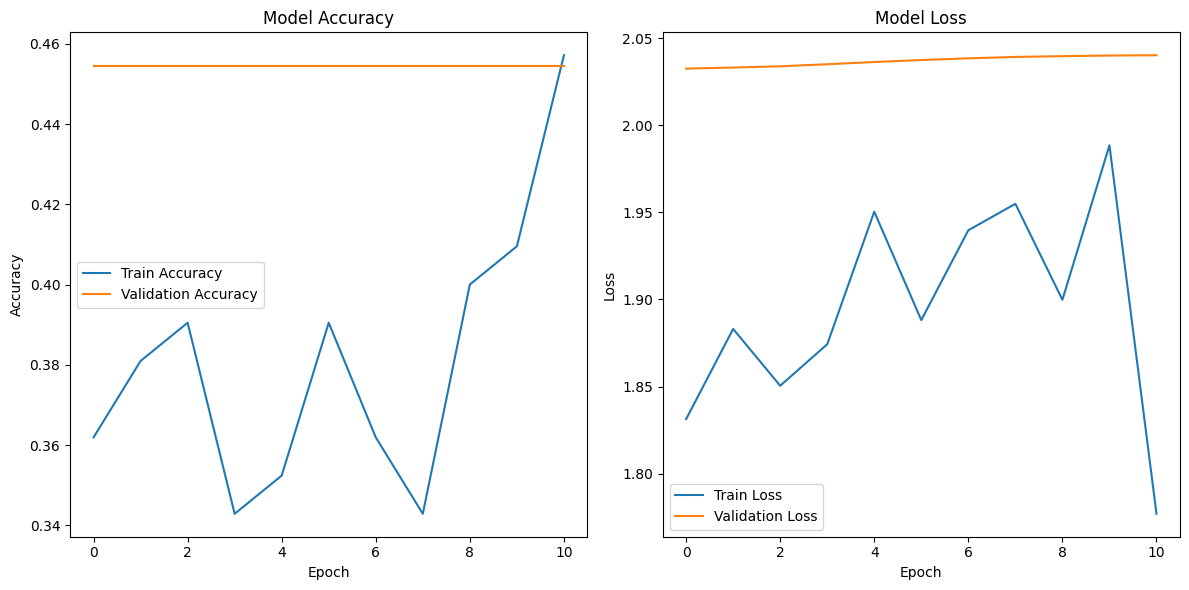

In [13]:
# Import required libraries
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience to allow more epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/custom_cnn_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot learning rate (if logged)
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3653 - loss: 1.9408
Epoch 1: val_loss improved from inf to 2.03286, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.3532 - loss: 1.9563 - val_accuracy: 0.4545 - val_loss: 2.0329 - learning_rate: 1.0000e-06
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3858 - loss: 1.8954
Epoch 2: val_loss did not improve from 2.03286
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.3791 - loss: 1.9114 - val_accuracy: 0.4545 - val_loss: 2.0336 - learning_rate: 1.0000e-06
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4181 - loss: 1.8175
Epoch 3: val_loss did not improve from 2.03286
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4126 - loss: 1.8183 - val_accuracy: 0.4545 - val_loss: 2.0340 - learning_rate: 1.0000e-06
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3891 - loss: 1.9220
Epoch 4: val_loss did not improve from 2.03286
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.3799 - loss: 1.9271 - val_accuracy: 0.4545 - val_loss: 2.0347 - learning_rate: 1.0000e-06
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc

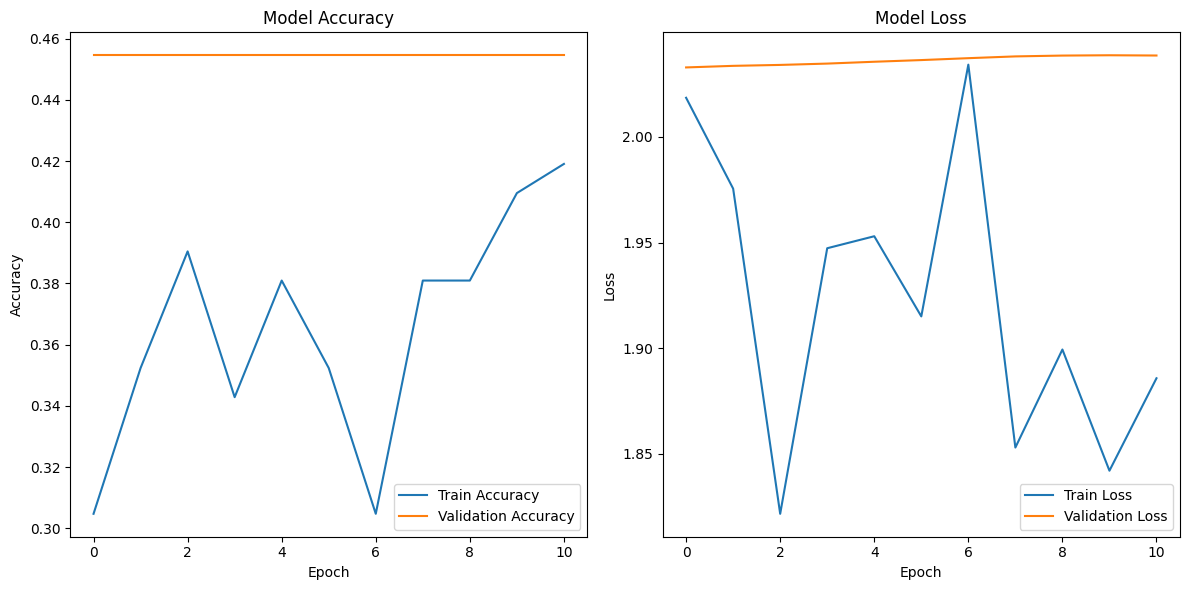

In [14]:
# Import required libraries
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience to allow more epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/custom_cnn_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot learning rate (if logged)
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3799 - loss: 1.9392
Epoch 1: val_loss improved from inf to 2.03321, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.3840 - loss: 1.9350 - val_accuracy: 0.4545 - val_loss: 2.0332 - learning_rate: 1.0000e-06
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4081 - loss: 1.8160
Epoch 2: val_loss did not improve from 2.03321
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.4141 - loss: 1.7988 - val_accuracy: 0.4545 - val_loss: 2.0338 - learning_rate: 1.0000e-06
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4297 - loss: 1.8303
Epoch 3: val_loss did not improve from 2.03321
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4218 - loss: 1.8344 - val_accuracy: 0.4545 - val_loss: 2.0343 - learning_rate: 1.0000e-06
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4053 - loss: 1.8214
Epoch 4: val_loss did not improve from 2.03321
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4061 - loss: 1.8478 - val_accuracy: 0.4545 - val_loss: 2.0350 - learning_rate: 1.0000e-06
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc

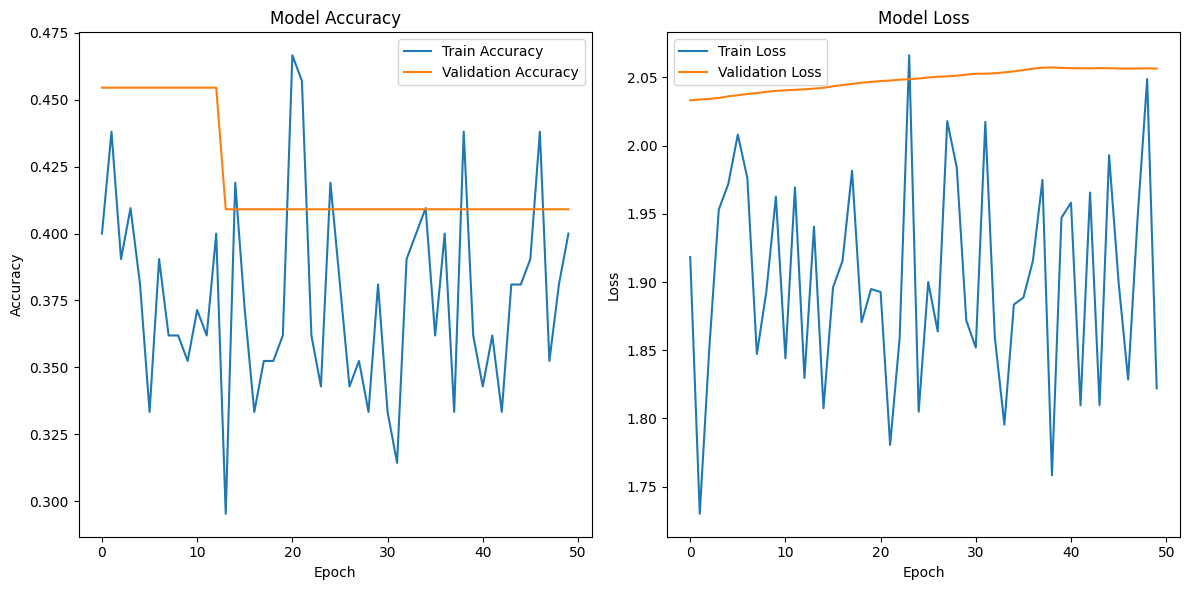

In [15]:
# Import required libraries
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/custom_cnn_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint],  # Removed early_stopping
    verbose=1
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot learning rate (if logged)
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3638 - loss: 2.0266
Epoch 1: val_loss improved from inf to 2.05692, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.3748 - loss: 2.0148 - val_accuracy: 0.4091 - val_loss: 2.0569 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3403 - loss: 1.7406
Epoch 2: val_loss did not improve from 2.05692
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.3389 - loss: 1.7761 - val_accuracy: 0.4091 - val_loss: 2.0579 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4407 - loss: 1.8405
Epoch 3: val_loss did not improve from 2.05692
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4364 - loss: 1.8502 - val_accuracy: 0.4091 - val_loss: 2.0584 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4239 - loss: 1.9812
Epoch 4: val_loss did not improve from 2.05692
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4210 - loss: 1.9804 - val_accuracy: 0.4091 - val_loss: 2.0587 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step -

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.2989 - loss: 1.9569 - val_accuracy: 0.4091 - val_loss: 2.0567 - learning_rate: 1.0000e-06
Epoch 90/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3263 - loss: 1.9800
Epoch 90: val_loss improved from 2.05670 to 2.05652, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.3277 - loss: 1.9756 - val_accuracy: 0.4091 - val_loss: 2.0565 - learning_rate: 1.0000e-06
Epoch 91/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3458 - loss: 1.9011
Epoch 91: val_loss improved from 2.05652 to 2.05608, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.3547 - loss: 1.8830 - val_accuracy: 0.4091 - val_loss: 2.0561 - learning_rate: 1.0000e-06
Epoch 92/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2824 - loss: 1.8502
Epoch 92: val_loss improved from 2.05608 to 2.05604, saving model to /content/drive/MyDrive/custom_cnn_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.2849 - loss: 1.8455 - val_accuracy: 0.4091 - val_loss: 2.0560 - learning_rate: 1.0000e-06
Epoch 93/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2855 - loss: 2.0402
Epoch 93: val_loss did not improve from 2.05604
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.3027 - loss: 2.0151 - val_accuracy: 0.4091 - val_loss: 2.0562 - learning_rate: 1.0000e-06
Epoch 94/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3752 - loss: 1.8147
Epoch 94: val_loss did not improve from 2.05604
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3726 - loss: 1.8273 - val_accuracy: 0.4091 - val_loss: 2.0564 - learning_rate: 1.0000e-06
Epoch 95/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3604 - loss: 1.9510
Epoch 95: val_loss did not improve from 2.05604
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.3683 - loss: 1.9443 - val_accuracy: 0.4091 - val_loss: 2.0567 - learning_rate: 1.0000e-06
Epoch 96/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s

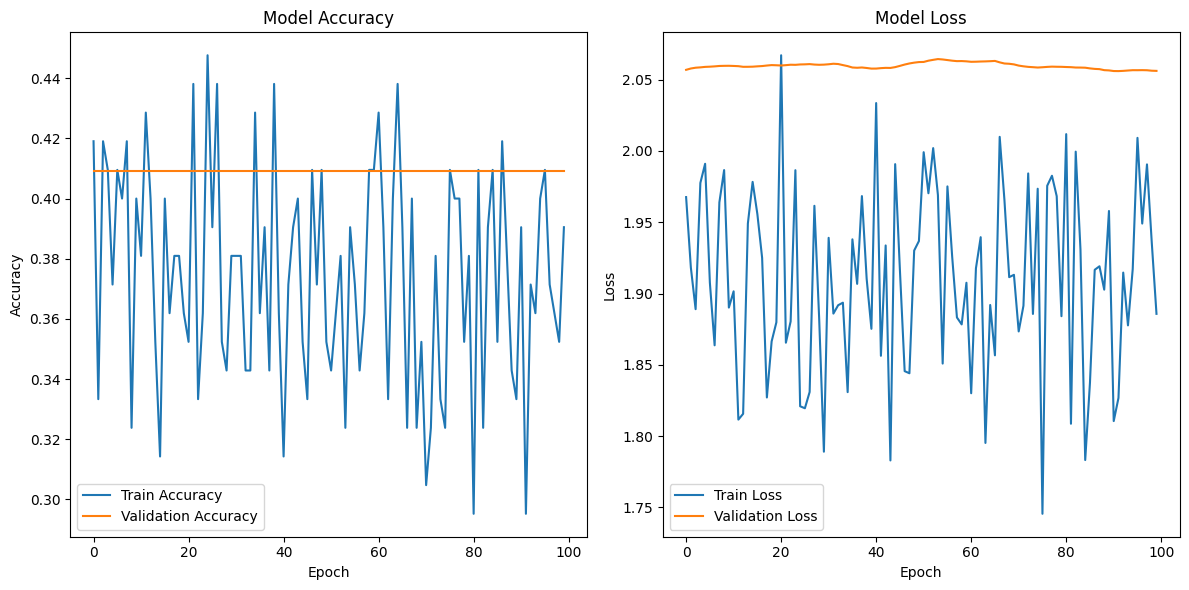

In [16]:
# Import required libraries
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/custom_cnn_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint],  # Removed early_stopping
    verbose=1
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot learning rate (if logged)
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

In [19]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

NameError: name 'model' is not defined

In [18]:
# Save the model
model.save('/content/drive/MyDrive/custom_cnn_plant_disease.h5')
print("Model saved successfully.")

Model saved successfully.


In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [29]:
# Load pre-trained MobileNetV2 (without top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers (unfreeze last 20 for fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the full model
transfer_model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a low learning rate for fine-tuning
transfer_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Summary of the model
transfer_model.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 1,371,983 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [30]:
import pandas as pd# Image parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(subset_paths, subset_labels, test_size=0.3, stratify=subset_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"Training images: {len(X_train)}, Validation images: {len(X_val)}, Test images: {len(X_test)}")

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation/test

# Function to create dataframe
def create_dataframe(paths, labels):
    return pd.DataFrame({'filename': paths, 'class': [str(label) for label in labels]})

# Create dataframes
train_df = create_dataframe(X_train, y_train)
val_df = create_dataframe(X_val, y_val)
test_df = create_dataframe(X_test, y_test)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Training images: 105, Validation images: 22, Test images: 23
Found 105 validated image filenames belonging to 15 classes.
Found 22 validated image filenames belonging to 15 classes.
Found 23 validated image filenames belonging to 15 classes.


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9455 - loss: 0.2832
Epoch 1: val_loss improved from inf to 0.77852, saving model to /content/drive/MyDrive/mobilenetv2_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9488 - loss: 0.2689 - val_accuracy: 0.7273 - val_loss: 0.7785 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9544 - loss: 0.1644
Epoch 2: val_loss did not improve from 0.77852
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9540 - loss: 0.1694 - val_accuracy: 0.7273 - val_loss: 0.7786 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9712 - loss: 0.1864
Epoch 3: val_loss did not improve from 0.77852
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9674 - loss: 0.1969 - val_accuracy: 0.7273 - val_loss: 0.7787 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9798 - loss: 0.1529
Epoch 4: val_loss improved from 0.77852 to 0.77836, saving model to /content/drive/MyDrive/mobilenetv2_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9782 - loss: 0.1569 - val_accuracy: 0.7273 - val_loss: 0.7784 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9549 - loss: 0.2230
Epoch 5: val_loss improved from 0.77836 to 0.77809, saving model to /content/drive/MyDrive/mobilenetv2_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9544 - loss: 0.2272 - val_accuracy: 0.7273 - val_loss: 0.7781 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9724 - loss: 0.1675
Epoch 6: val_loss improved from 0.77809 to 0.77798, saving model to /content/drive/MyDrive/mobilenetv2_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9703 - loss: 0.1670 - val_accuracy: 0.7273 - val_loss: 0.7780 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9571 - loss: 0.1769
Epoch 7: val_loss improved from 0.77798 to 0.77793, saving model to /content/drive/MyDrive/mobilenetv2_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9542 - loss: 0.1843 - val_accuracy: 0.7273 - val_loss: 0.7779 - learning_rate: 1.0000e-06
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9405 - loss: 0.1949
Epoch 8: val_loss did not improve from 0.77793
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9429 - loss: 0.1947 - val_accuracy: 0.7273 - val_loss: 0.7779 - learning_rate: 1.0000e-06
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9425 - loss: 0.2437
Epoch 9: val_loss improved from 0.77793 to 0.77785, saving model to /content/drive/MyDrive/mobilenetv2_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9426 - loss: 0.2393 - val_accuracy: 0.7273 - val_loss: 0.7778 - learning_rate: 1.0000e-06
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9721 - loss: 0.2134
Epoch 10: val_loss improved from 0.77785 to 0.77769, saving model to /content/drive/MyDrive/mobilenetv2_best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9720 - loss: 0.2079 - val_accuracy: 0.7273 - val_loss: 0.7777 - learning_rate: 1.0000e-06
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9593 - loss: 0.1513
Epoch 11: val_loss did not improve from 0.77769
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9579 - loss: 0.1526 - val_accuracy: 0.7273 - val_loss: 0.7778 - learning_rate: 1.0000e-06
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9748 - loss: 0.1788
Epoch 12: val_loss did not improve from 0.77769
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9741 - loss: 0.1812 - val_accuracy: 0.7273 - val_loss: 0.7779 - learning_rate: 1.0000e-06
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9721 - loss: 0.2352
Epoch 13: val_loss did not improve from 0.77769
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9720 - loss: 0.2286 - val_accuracy: 0.7273 - val_loss: 0.7779 - learning_rate: 1.0000e-06
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/st

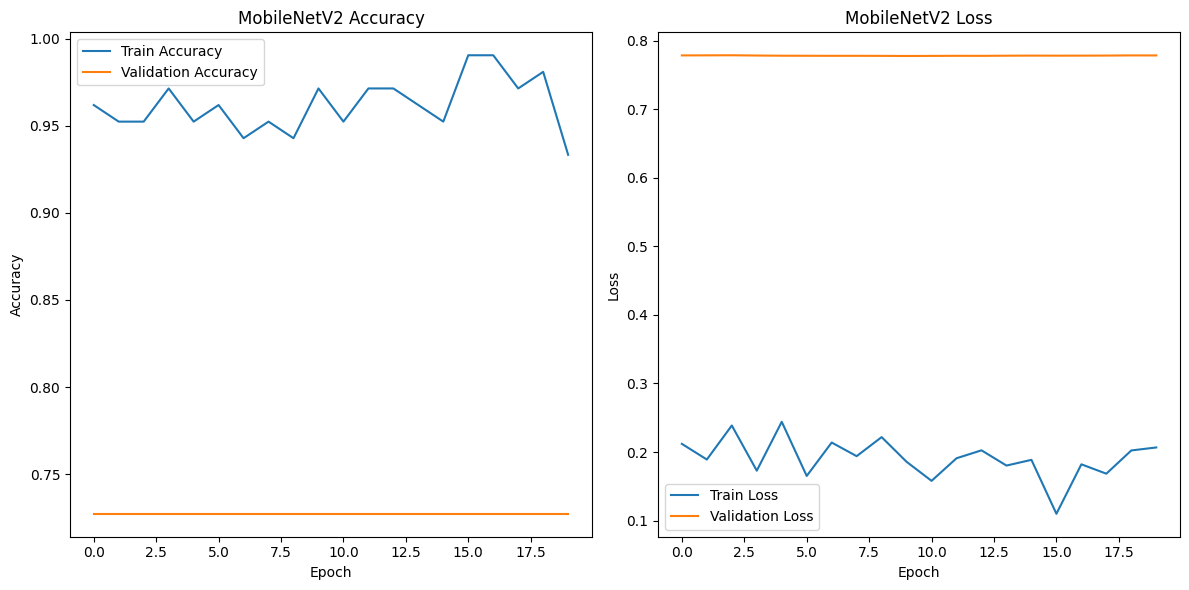

In [56]:
# Define callbacks (similar to CNN, but for MobileNetV2)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/mobilenetv2_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = transfer_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot learning rate (if logged)
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5652 - loss: 1.2519
Test Accuracy: 0.5652
Test Loss: 1.2519
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00         1
                     Pepper__bell___healthy       0.67      1.00      0.80         2
                      Potato___Early_blight       0.33      0.50      0.40         2
                       Potato___Late_blight       0.00      0.00      0.00         1
                           Potato___healthy       1.00      0.50      0.67         2
                      Tomato_Bacterial_spot       0.20      1.00      0.33         1
                        Tomato_Early_blight       0.00      0.00      0.00         2
                         Tomato_Late_blight       1.00      1.00      1.00         1
                           Tomato_Leaf_Mold       0.67      1.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


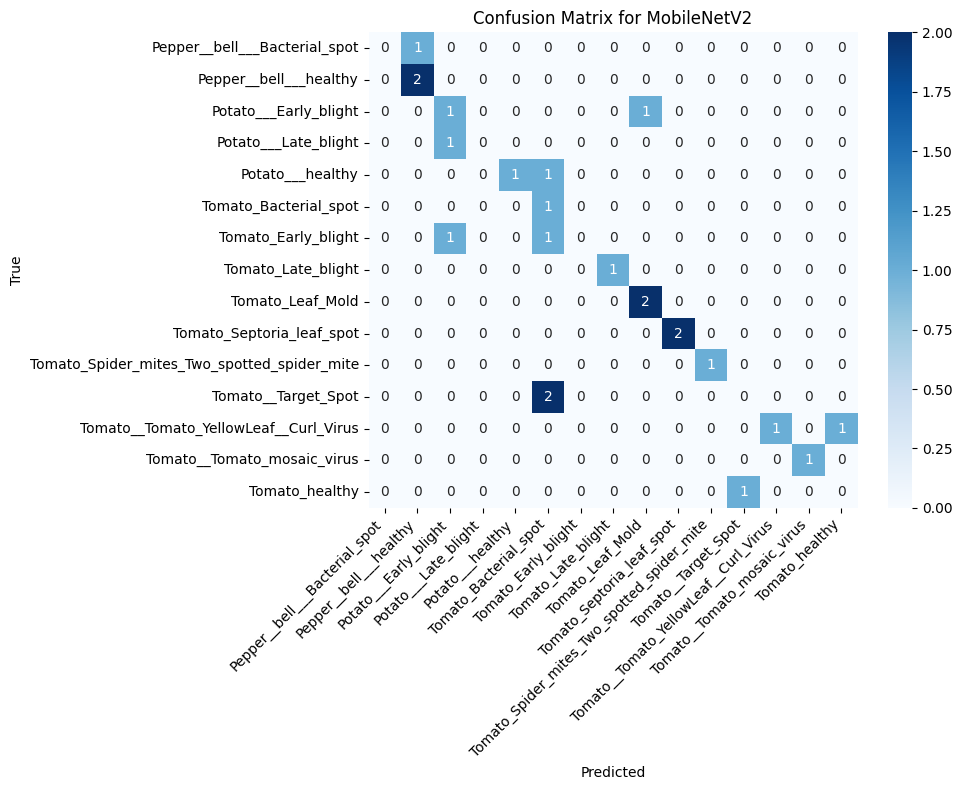

In [57]:
# Evaluate on test set
test_loss, test_accuracy = transfer_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
y_pred = transfer_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for MobileNetV2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [58]:
# Save the model as .h5
transfer_model.save('/content/drive/MyDrive/mobilenetv2_plant_disease.h5')
print("Model saved successfully as .h5")

Model saved successfully as .h5


In [17]:
# Example comparison (replace with actual metrics from evaluation)
comparison = pd.DataFrame({
    'Model': ['Custom CNN', 'MobileNetV2'],
    'Test Accuracy': [cnn_accuracy, test_accuracy],  # From evaluate() outputs
    'Test Loss': [cnn_loss, test_loss],
    'Precision': [cnn_precision, mobilenet_precision],  # From classification_report
    'Recall': [cnn_recall, mobilenet_recall],
    'F1-Score': [cnn_f1, mobilenet_f1]
})
print(comparison)

NameError: name 'cnn_accuracy' is not defined

In [59]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define class names
class_names = [
    'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight',
    'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot',
    'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'
]

# Load the saved models
cnn_model = load_model('/content/drive/MyDrive/custom_cnn_plant_disease.h5')
mobilenet_model = load_model('/content/drive/MyDrive/mobilenetv2_plant_disease.h5')

print("Both models loaded successfully.")

Both models loaded successfully.


In [60]:
# Evaluate Custom CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_generator)
print(f"Custom CNN - Test Accuracy: {cnn_accuracy:.4f}, Test Loss: {cnn_loss:.4f}")

# Get predictions for CNN
cnn_pred = cnn_model.predict(test_generator)
cnn_pred_classes = np.argmax(cnn_pred, axis=1)
y_true = test_generator.classes

# Classification report for CNN
cnn_report = classification_report(y_true, cnn_pred_classes, target_names=class_names, output_dict=True)
cnn_precision = cnn_report['weighted avg']['precision']
cnn_recall = cnn_report['weighted avg']['recall']
cnn_f1 = cnn_report['weighted avg']['f1-score']

print("\nCustom CNN Classification Report:")
print(classification_report(y_true, cnn_pred_classes, target_names=class_names))

# Evaluate MobileNetV2
mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(test_generator)
print(f"MobileNetV2 - Test Accuracy: {mobilenet_accuracy:.4f}, Test Loss: {mobilenet_loss:.4f}")

# Get predictions for MobileNetV2
mobilenet_pred = mobilenet_model.predict(test_generator)
mobilenet_pred_classes = np.argmax(mobilenet_pred, axis=1)

# Classification report for MobileNetV2
mobilenet_report = classification_report(y_true, mobilenet_pred_classes, target_names=class_names, output_dict=True)
mobilenet_precision = mobilenet_report['weighted avg']['precision']
mobilenet_recall = mobilenet_report['weighted avg']['recall']
mobilenet_f1 = mobilenet_report['weighted avg']['f1-score']

print("\nMobileNetV2 Classification Report:")
print(classification_report(y_true, mobilenet_pred_classes, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2174 - loss: 2.4312
Custom CNN - Test Accuracy: 0.2174, Test Loss: 2.4312
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Custom CNN Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00         1
                     Pepper__bell___healthy       1.00      0.50      0.67         2
                      Potato___Early_blight       1.00      0.50      0.67         2
                       Potato___Late_blight       0.00      0.00      0.00         1
                           Potato___healthy       0.00      0.00      0.00         2
                      Tomato_Bacterial_spot       1.00      1.00      1.00         1
                        Tomato_Early_blight       1.00      0.50      0.67         2
                         Tomato_Late_blight       0.00      0.00      0.00         1
                           Tomato_Leaf_

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5652 - loss: 1.2519
MobileNetV2 - Test Accuracy: 0.5652, Test Loss: 1.2519
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

MobileNetV2 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00         1
                     Pepper__bell___healthy       0.67      1.00      0.80         2
                      Potato___Early_blight       0.33      0.50      0.40         2
                       Potato___Late_blight       0.00      0.00      0.00         1
                           Potato___healthy       1.00      0.50      0.67         2
                      Tomato_Bacterial_spot       0.20      1.00      0.33         1
                        Tomato_Early_blight       0.00      0.00      0.00         2
                         Tomato_Late_blight       1.00      1.00      1.00         1
                           Tomato_Lea

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Model Comparison:
         Model  Test Accuracy  Test Loss  Precision    Recall  F1-Score
0   Custom CNN       0.217391   2.431191   0.311594  0.217391  0.229814
1  MobileNetV2       0.565217   1.251882   0.544928  0.565217  0.521739


<Figure size 1000x600 with 0 Axes>

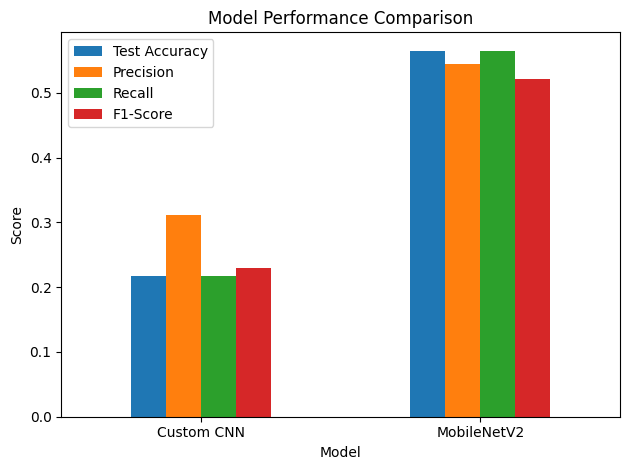

In [61]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Custom CNN', 'MobileNetV2'],
    'Test Accuracy': [cnn_accuracy, mobilenet_accuracy],
    'Test Loss': [cnn_loss, mobilenet_loss],
    'Precision': [cnn_precision, mobilenet_precision],
    'Recall': [cnn_recall, mobilenet_recall],
    'F1-Score': [cnn_f1, mobilenet_f1]
})

print("\nModel Comparison:")
print(comparison)

# Optional: Visualize comparison
plt.figure(figsize=(10, 6))
comparison.set_index('Model')[['Test Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Both models loaded successfully.
Please upload an image file (e.g., .jpg, .png):


Saving 0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG to 0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG
Uploaded image: 0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG
Image preprocessed: 0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Custom CNN Prediction:
Predicted Class: Pepper__bell___Bacterial_spot
Confidence: 0.5363

MobileNetV2 Prediction:
Predicted Class: Pepper__bell___Bacterial_spot
Confidence: 0.9971

Custom CNN Top-5 Predictions:
Pepper__bell___Bacterial_spot: 0.5363
Tomato__Target_Spot: 0.1039
Tomato_Leaf_Mold: 0.0890
Tomato__Tomato_YellowLeaf__Curl_Virus: 0.0617
Potato___healthy: 0.0536

MobileNetV2 Top-5 Predictions:
Pepper__bell___Bacterial_spot: 0.9971
Pepper__bell___healthy: 0.0025
Tomato_Bacterial_spot: 0.0001
Potato___Late_blight: 0.0001
Tomato_Late_blight: 0.0001


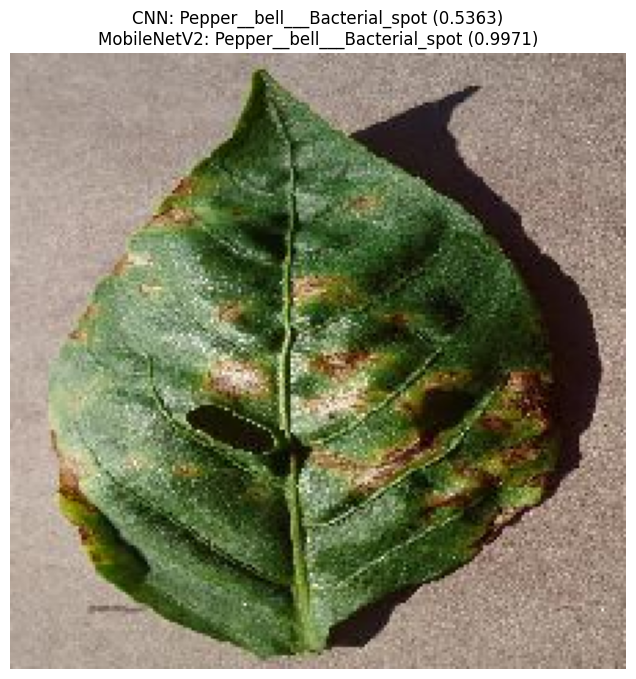

In [66]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from google.colab import files

# Define class names
class_names = [
    'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight',
    'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot',
    'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'
]

# Load the saved models
cnn_model = load_model('/content/drive/MyDrive/custom_cnn_plant_disease.h5')
mobilenet_model = load_model('/content/drive/MyDrive/mobilenetv2_plant_disease.h5')
print("Both models loaded successfully.")

# Upload image
print("Please upload an image file (e.g., .jpg, .png):")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name
print(f"Uploaded image: {image_path}")

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Rescale to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

# Preprocess the image
img, img_array = preprocess_image(image_path)
print(f"Image preprocessed: {image_path}")

# Make predictions
cnn_pred = cnn_model.predict(img_array)
mobilenet_pred = mobilenet_model.predict(img_array)

# Get predicted classes and confidence scores
cnn_pred_class = np.argmax(cnn_pred[0])
cnn_confidence = cnn_pred[0][cnn_pred_class]
mobilenet_pred_class = np.argmax(mobilenet_pred[0])
mobilenet_confidence = mobilenet_pred[0][mobilenet_pred_class]

# Map to class names
cnn_pred_label = class_names[cnn_pred_class]
mobilenet_pred_label = class_names[mobilenet_pred_class]

# Print results
print("\nCustom CNN Prediction:")
print(f"Predicted Class: {cnn_pred_label}")
print(f"Confidence: {cnn_confidence:.4f}")

print("\nMobileNetV2 Prediction:")
print(f"Predicted Class: {mobilenet_pred_label}")
print(f"Confidence: {mobilenet_confidence:.4f}")

# Display top-5 predictions
cnn_top5 = np.argsort(cnn_pred[0])[::-1][:5]
mobilenet_top5 = np.argsort(mobilenet_pred[0])[::-1][:5]

print("\nCustom CNN Top-5 Predictions:")
for idx in cnn_top5:
    print(f"{class_names[idx]}: {cnn_pred[0][idx]:.4f}")

print("\nMobileNetV2 Top-5 Predictions:")
for idx in mobilenet_top5:
    print(f"{class_names[idx]}: {mobilenet_pred[0][idx]:.4f}")

# Display the image with predictions
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f"CNN: {cnn_pred_label} ({cnn_confidence:.4f})\nMobileNetV2: {mobilenet_pred_label} ({mobilenet_confidence:.4f})")
plt.axis('off')
plt.show()